## Imports

In [1]:
# IMPORTS
# Took some code from: https://www.kaggle.com/code/mohamedsameh0410/brain-tumor-classification-using-cnn-acc-99/notebook

import os
import itertools


import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
from helper_functions import data_cropping

sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')


## <div style='background-color:darkseagreen; width: 100%; padding: 10px;'>Data loading</div>

### Data set 1: data loading , final version (CLAHE, no norm, crop and resize)

In [2]:
# ADD CONTRAST

train_data_dir = 'Data set 1/Training'
filepaths = []
labels = []

# Function to apply CLAHE to the input image
def apply_clahe(image):
    if image.dtype != 'uint8':
        # Convert image to 8-bit unsigned integer
        image = cv2.convertScaleAbs(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
    clahe_image = clahe.apply(image)
    return clahe_image


# Get folders names
folds = [f for f in os.listdir(train_data_dir) if not f.startswith('.')]

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        # Load the image using cv2.imread
        image = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        
         # Apply data cropping function
        if image is not None:
            cropped_image = data_cropping(image)
            
            # Apply CLAHE to the image
            clahe_image = apply_clahe(cropped_image)
            
            # Define the path to save the preprocessed image
            preprocessed_dir = 'Preprocessed'
            os.makedirs(preprocessed_dir, exist_ok=True)
            preprocessed_filepath = os.path.join(preprocessed_dir, f'{fold}_{file}')
            
            cv2.imwrite(preprocessed_filepath, clahe_image)
            
            # Add the preprocessed file path and label to the lists
            filepaths.append(preprocessed_filepath)
            labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis=1)


In [3]:
train_df

,filepaths,labels
0,Preprocessed/no_tumor_image(115).jpg,no_tumor
1,Preprocessed/no_tumor_image(257)_augmented_2.jpg,no_tumor
2,Preprocessed/no_tumor_image(269)_augmented_2.jpg,no_tumor
3,Preprocessed/no_tumor_image(34)_augmented_2.jpg,no_tumor
4,Preprocessed/no_tumor_image (56)_augmented_1.jpg,no_tumor
...,...,...
8605,Preprocessed/pituitary_tumor_p (164)_augmented...,pituitary_tumor
8606,Preprocessed/pituitary_tumor_p (359)_augmented...,pituitary_tumor
8607,Preprocessed/pituitary_tumor_p (726).jpg,pituitary_tumor
8608,Preprocessed/pituitary_tumor_p (367)_augmented...,pituitary_tumor


In [34]:

import os
import pandas as pd
import cv2
from helper_functions import data_cropping

test_data_dir = 'Data set 1/Testing'
filepaths = []
labels = []

# Function to apply CLAHE to the input image
def apply_clahe(image):
    if image.dtype != 'uint8':
        # Convert image to 8-bit unsigned integer
        image = cv2.convertScaleAbs(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
    clahe_image = clahe.apply(image)
    return clahe_image



# Get folders names
folds = [f for f in os.listdir(test_data_dir) if not f.startswith('.')]

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        if file.startswith('.'):
            continue  # Skip .DS_Store and other hidden files
        fpath = os.path.join(foldpath, file)
        
        # Load the image using cv2.imread
        image = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        
        # Apply data cropping function
        if image is not None:
            cropped_image = data_cropping(image)
            clahe_image = apply_clahe(cropped_image)
            
            if clahe_image is not None:
                preprocessed_dir = 'Preprocessed'
                os.makedirs(preprocessed_dir, exist_ok=True)
                preprocessed_filepath = os.path.join(preprocessed_dir, f'{fold}_{file}')

                # Save the preprocessed image
                cv2.imwrite(preprocessed_filepath, clahe_image)

                # Add the preprocessed file path and label to the lists
                filepaths.append(preprocessed_filepath)
                labels.append(fold)

        else:
            print(f"Error loading image: {fpath}")

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [35]:
ts_df

,filepaths,labels
0,Preprocessed/no_tumor_image(49).jpg,no_tumor
1,Preprocessed/no_tumor_image(1).jpg,no_tumor
2,Preprocessed/no_tumor_image(103).jpg,no_tumor
3,Preprocessed/no_tumor_image(73).jpg,no_tumor
4,Preprocessed/no_tumor_image(24).jpg,no_tumor
...,...,...
389,Preprocessed/pituitary_tumor_image(70).jpg,pituitary_tumor
390,Preprocessed/pituitary_tumor_image(27).jpg,pituitary_tumor
391,Preprocessed/pituitary_tumor_image(31).jpg,pituitary_tumor
392,Preprocessed/pituitary_tumor_image(66).jpg,pituitary_tumor


### Data loading set 1 with augmentation

In [32]:
import os
import pandas as pd
import cv2
from PIL import Image
from helper_functions import data_cropping
from torchvision import transforms

# Define data augmentation transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # Randomly flip the image horizontally
    transforms.RandomRotation(5),         # Randomly rotate the image by up to 5 degrees
])

# Number of augmentations to perform
num_augmentations = 2

train_data_dir = '../archive/Training'
filepaths = []
labels = []

# Get folders names
folds = [f for f in os.listdir(train_data_dir) if not f.startswith('.')]

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        if file.startswith('.'):
            continue  # Skip .DS_Store and other hidden files
        fpath = os.path.join(foldpath, file)
        
        # Load the image using PIL.Image
        image = Image.open(fpath)
        
        # Apply data cropping function
        image_np = cv2.imread(fpath)
        if image_np is not None:
            cropped_image = data_cropping(image_np)
            if cropped_image is not None:
                # Convert cropped image to PIL Image
                cropped_image = Image.fromarray(cropped_image)
                
                # Apply data augmentation transformations multiple times
                for _ in range(num_augmentations):
                    augmented_image = data_transforms(cropped_image)
                    
                    # Save the augmented image
                    augmented_filepath = fpath[:-4] + f'_augmented_{_ + 1}.jpg'  # Adjust the file extension as needed
                    augmented_image.save(augmented_filepath)
                    
                    filepaths.append(augmented_filepath)
                    labels.append(fold)
        else:
            print(f"Error loading image: {fpath}")

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis=1)


In [33]:
train_df

,filepaths,labels
0,../archive/Training/no_tumor/image(115)_augmen...,no_tumor
1,../archive/Training/no_tumor/image(115)_augmen...,no_tumor
2,../archive/Training/no_tumor/image(142)_augmen...,no_tumor
3,../archive/Training/no_tumor/image(142)_augmen...,no_tumor
4,../archive/Training/no_tumor/image(49)_augment...,no_tumor
...,...,...
5735,../archive/Training/pituitary_tumor/p (233)_au...,pituitary_tumor
5736,../archive/Training/pituitary_tumor/p (726)_au...,pituitary_tumor
5737,../archive/Training/pituitary_tumor/p (726)_au...,pituitary_tumor
5738,../archive/Training/pituitary_tumor/p (376)_au...,pituitary_tumor


### Data set 2 loading

In [61]:
# Generate data paths with labels
train_data_dir = 'Data set 2/Training'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [62]:
train_df

,filepaths,labels
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,Training/meningioma/Tr-me_1053.jpg,meningioma
5708,Training/meningioma/Tr-me_0403.jpg,meningioma
5709,Training/meningioma/Tr-me_0365.jpg,meningioma
5710,Training/meningioma/Tr-me_0371.jpg,meningioma


In [88]:
# Generate data paths with labels
train_data_dir = 'Data set 2/Testing'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [89]:
ts_df

,filepaths,labels
0,Testing/pituitary/Te-pi_0233.jpg,pituitary
1,Testing/pituitary/Te-pi_0227.jpg,pituitary
2,Testing/pituitary/Te-pi_0019.jpg,pituitary
3,Testing/pituitary/Te-pi_0031.jpg,pituitary
4,Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,Testing/meningioma/Te-me_0080.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0137.jpg,meningioma
1309,Testing/meningioma/Te-me_0123.jpg,meningioma


In [47]:
import cv2
import os
import pandas as pd

# Function to apply CLAHE to the input image
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # You can adjust the parameters as needed
    clahe_image = clahe.apply(image)
    return clahe_image

# Generate data paths with labels
train_data_dir = 'Training'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        # Read the image
        image = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        
        # Apply CLAHE to the image
        clahe_image = apply_clahe(image)
        
        # Define the path to save the preprocessed image
        preprocessed_dir = 'Preprocessed'
        os.makedirs(preprocessed_dir, exist_ok=True)
        preprocessed_filepath = os.path.join(preprocessed_dir, f'{fold}_{file}')
        
        # Save the preprocessed image
        cv2.imwrite(preprocessed_filepath, clahe_image)
        
        # Add the preprocessed file path and label to the lists
        filepaths.append(preprocessed_filepath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis=1)

In [48]:
train_df

,filepaths,labels
0,Preprocessed/pituitary_Tr-pi_0505.jpg,pituitary
1,Preprocessed/pituitary_Tr-pi_0263.jpg,pituitary
2,Preprocessed/pituitary_Tr-pi_0277.jpg,pituitary
3,Preprocessed/pituitary_Tr-pi_1169.jpg,pituitary
4,Preprocessed/pituitary_Tr-pi_0511.jpg,pituitary
...,...,...
5707,Preprocessed/meningioma_Tr-me_1053.jpg,meningioma
5708,Preprocessed/meningioma_Tr-me_0403.jpg,meningioma
5709,Preprocessed/meningioma_Tr-me_0365.jpg,meningioma
5710,Preprocessed/meningioma_Tr-me_0371.jpg,meningioma


In [57]:
import cv2
import os
import pandas as pd

# Function to apply CLAHE to the input image
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # You can adjust the parameters as needed
    clahe_image = clahe.apply(image)
    return clahe_image

# Generate data paths with labels
test_data_dir = 'Testing'
filepaths = []
labels = []

# Get folders names
folds = [f for f in os.listdir(test_data_dir) if not f.startswith('.')]

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    
    filelist = os.listdir(foldpath)
    for file in filelist:
        if file.startswith('.'):
            continue  # Skip .DS_Store and other hidden files
        fpath = os.path.join(foldpath, file)
        
        # Read the image
        image = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        
        # Apply CLAHE to the image
        clahe_image = apply_clahe(image)
        
        # Define the path to save the preprocessed image
        preprocessed_dir = 'Preprocessed'
        os.makedirs(preprocessed_dir, exist_ok=True)
        preprocessed_filepath = os.path.join(preprocessed_dir, f'{fold}_{file}')
        
        # Save the preprocessed image
        cv2.imwrite(preprocessed_filepath, clahe_image)
        
        # Add the preprocessed file path and label to the lists
        filepaths.append(preprocessed_filepath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis=1)


In [ ]:
import hashlib
from settings import PROJECT_DIR, LABELS

# There are duplicates apparently

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, 'data', 'raw', data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)

### Train and test sets

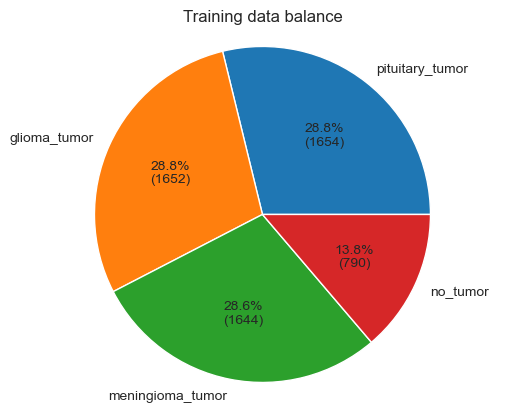

In [37]:
data_balance = train_df.labels.value_counts()

def printper(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance, labels=data_balance.index, autopct=printper)
plt.title("Training data balance")
plt.axis("equal")
#plt.savefig("data1_pie_chart.png")
plt.show()


In [38]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
img_size = (224, 224)

# Just load the data, by default the settings do not augment my images 
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# generates batches for each set 
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',  shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', shuffle= False, batch_size= batch_size)

Found 5740 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


In [74]:
# NORMALISATION 

rescale_factor = 1.0 / 255.0  # Scale pixel values to range [0, 1]

ts_gen = ImageDataGenerator(
    rescale=rescale_factor
)
tr_gen = ImageDataGenerator(
    rescale=rescale_factor
)
# cropped image size
batch_size = 64
img_size = (224, 224)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    shuffle=False,  
    batch_size=batch_size
)


Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


In [ ]:
# Representation of random images in the train set

g_dict = train_gen.class_indices 
classes = list(g_dict.keys())     
images, labels = next(train_gen)  
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes[index]  
    plt.title(class_name, color='black', fontsize=16)
    plt.axis('off')

plt.tight_layout()


plt.show()

## <div style='background-color:darkseagreen; width: 100%; padding: 10px;'>Search: Grid and Bayesian</div>

### Hyper parameter search

In [102]:
dense_layers = [0,1,2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense_data1".format(conv_layer, layer_size, dense_layer)
            print(NAME)
     

1-conv-32-nodes-0-dense_data1
2-conv-32-nodes-0-dense_data1
3-conv-32-nodes-0-dense_data1
1-conv-64-nodes-0-dense_data1
2-conv-64-nodes-0-dense_data1
3-conv-64-nodes-0-dense_data1
1-conv-32-nodes-1-dense_data1
2-conv-32-nodes-1-dense_data1
3-conv-32-nodes-1-dense_data1
1-conv-64-nodes-1-dense_data1
2-conv-64-nodes-1-dense_data1
3-conv-64-nodes-1-dense_data1
1-conv-32-nodes-2-dense_data1
2-conv-32-nodes-2-dense_data1
3-conv-32-nodes-2-dense_data1
1-conv-64-nodes-2-dense_data1
2-conv-64-nodes-2-dense_data1
3-conv-64-nodes-2-dense_data1


In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import pickle
import time
import numpy as np
import keras.optimizers
from sklearn.metrics import classification_report

img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)


tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

result_dict = {}

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense_data1".format(conv_layer, layer_size, dense_layer)
            print(NAME)
            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3),activation="relu", input_shape= img_shape))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1): 
                model.add(Conv2D(layer_size, (3, 3), activation="relu"))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())
            for _ in range(dense_layer):
                model.add(Dense(layer_size, activation="relu"))
                model.add(Dropout(0.2))

            model.add(Dense(4, activation = "softmax"))


            model.compile(loss='categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'],
              )
            
            #Fit the model
            history = model.fit(train_gen,
                batch_size=32,
                epochs=15,
                validation_data= valid_gen,
                callbacks=[tensorboard,es]
            )
            train_acc = history.history['accuracy']
            train_loss = history.history['loss']
            val_acc = history.history['val_accuracy']
            val_loss = history.history['val_loss']   
            result_dict[NAME]= {
                'train_acc': train_acc,
                'train_loss': train_loss,
                'val_acc': val_acc,
                'val_loss': val_loss
            }
            
            #Score 
            scores = model.evaluate(test_gen, verbose=1) 
            print('Test loss:', scores[0])
            print('Test accuracy:', scores[1])
            
            #Save model
            model.save("{}-model-{}-accuracy.h5".format(NAME,scores[1]))
            
            #precision    recall  f1-score   support
           # y_pred = model.predict(X_test, batch_size=64, verbose=1)
            #y_pred_bool = np.argmax(y_pred, axis=1)
            #print(classification_report(Y_test, y_pred_bool))
            print()
            print()  

with open('Loss_Acc_Dataset1.pkl', 'wb') as fp:
    pickle.dump(result_dict, fp)
    print('dictionary saved successfully to file')
     

1-conv-32-nodes-0-dense_data1
Epoch 1/15
180/180 [==============================] - 15s 82ms/step - loss: 138.2336 - accuracy: 0.6777 - val_loss: 36.9594 - val_accuracy: 0.5990
Epoch 2/15
180/180 [==============================] - 15s 81ms/step - loss: 1.2154 - accuracy: 0.9202 - val_loss: 51.8482 - val_accuracy: 0.5990
Epoch 3/15
180/180 [==============================] - 14s 79ms/step - loss: 0.6315 - accuracy: 0.9578 - val_loss: 35.0102 - val_accuracy: 0.6599
Epoch 4/15
180/180 [==============================] - 15s 81ms/step - loss: 0.2120 - accuracy: 0.9861 - val_loss: 36.2662 - val_accuracy: 0.6650
Epoch 5/15
180/180 [==============================] - 14s 79ms/step - loss: 0.1184 - accuracy: 0.9829 - val_loss: 43.4782 - val_accuracy: 0.6447
Epoch 6/15
180/180 [==============================] - 14s 78ms/step - loss: 0.1842 - accuracy: 0.9882 - val_loss: 51.7641 - val_accuracy: 0.5939
Epoch 7/15
180/180 [==============================] - 14s 76ms/step - loss: 0.2297 - accuracy: 0.9

In [113]:
# Re open the files where the accuracy is stored
with open('Loss_Acc_Dataset1.pkl', 'rb') as fp:
    result_dict = pickle.load(fp)
    print(result_dict['3-conv-32-nodes-0-dense_data1'])

{'train_acc': [0.6487804651260376, 0.8390243649482727, 0.895470380783081, 0.9355400800704956, 0.9578397274017334, 0.9696863889694214], 'train_loss': [4.156659126281738, 0.464648962020874, 0.28057020902633667, 0.1885976344347, 0.12727349996566772, 0.08908050507307053], 'val_acc': [0.49238577485084534, 0.5786802172660828, 0.6395938992500305, 0.6548223495483398, 0.6802030205726624, 0.7157360315322876], 'val_loss': [2.2483110427856445, 2.8501651287078857, 3.238166093826294, 3.7612736225128174, 4.305922508239746, 4.342068672180176]}


### Bayesian search

In [26]:
import kerastuner as kt
import numpy as np


def build_model(hp):

    img_size = (224, 224)
    channels = 1
    img_shape = (img_size[0], img_size[1], channels)

    class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_initializer='he_uniform', kernel_size=(3,3), padding="same", input_shape= img_shape))
    model.add(Activation("relu"))  # Add activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32,kernel_initializer='he_uniform',  kernel_size=(3,3), padding="same"))
    model.add(Activation("relu"))  # Add activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32,kernel_initializer='he_uniform',  kernel_size=(3,3), padding="same"))
    model.add(Activation("relu"))  # Add activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(class_count, activation="softmax"))



    # learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    
    # batch size
    hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128])
    
    # Compile
    model.compile(optimizer=Adamax(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of search iterations
    directory='tuner_dir_2', 
    project_name='batch_lr_search'  
)


tuner.search(train_gen, validation_data=valid_gen, epochs=10)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
print(f"Optimal batch size: {best_hps.get('batch_size')}")

Trial 10 Complete [00h 02m 35s]
val_accuracy: 0.7208121418952942

Best val_accuracy So Far: 0.7208121418952942
Total elapsed time: 00h 23m 19s
Optimal learning rate: 0.01
Optimal batch size: 16


## <div style='background-color:darkseagreen; width: 100%; padding: 10px;'>Training and Testing</div>

### Training for Dataset 1

In [18]:
# Original model structure


img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) 

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", ))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", ))
model.add(MaxPooling2D())
    
model.add(Flatten())
#model.add(Dense(64,activation = "relu"))
#model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))




In [40]:
# Imroved model structure

from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Activation
img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) 


model = Sequential()

model.add(Conv2D(filters=32, kernel_initializer='he_uniform', kernel_size=(3,3), padding="same", input_shape= img_shape))
model.add(Activation("relu"))  
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32,kernel_initializer='he_uniform',  kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))  
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32,kernel_initializer='he_uniform',  kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))  
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(class_count, activation="softmax"))

In [ ]:
# Compile the model before training
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

In [ ]:
# Model representation
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [42]:
epochs = 15   # number of all epochs in training
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          #write_graph=True, write_images=False)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)


Epoch 1/15
90/90 [==============================] - 35s 341ms/step - loss: 1.5443 - accuracy: 0.6655 - val_loss: 9.0326 - val_accuracy: 0.3756
Epoch 2/15
90/90 [==============================] - 30s 337ms/step - loss: 0.4002 - accuracy: 0.8491 - val_loss: 5.7347 - val_accuracy: 0.4518
Epoch 3/15
90/90 [==============================] - 31s 343ms/step - loss: 0.2320 - accuracy: 0.9213 - val_loss: 4.7690 - val_accuracy: 0.4924
Epoch 4/15
90/90 [==============================] - 27s 290ms/step - loss: 0.1471 - accuracy: 0.9557 - val_loss: 4.1819 - val_accuracy: 0.5482
Epoch 5/15
90/90 [==============================] - 25s 279ms/step - loss: 0.1131 - accuracy: 0.9655 - val_loss: 4.6613 - val_accuracy: 0.5736
Epoch 6/15
90/90 [==============================] - 26s 285ms/step - loss: 0.0709 - accuracy: 0.9847 - val_loss: 4.2388 - val_accuracy: 0.5888
Epoch 7/15
90/90 [==============================] - 25s 277ms/step - loss: 0.0487 - accuracy: 0.9941 - val_loss: 4.0142 - val_accuracy: 0.5838

### Training for Dataset 2

In [77]:
# Model for data set 2 : 3 Conv 128, 1 dense 128
img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", ))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", ))
model.add(MaxPooling2D())
    
model.add(Flatten())
model.add(Dense(128,activation = "relu"))
#model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))




In [ ]:
# Compile the model 

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

In [ ]:
# Train the model 
epochs = 10  
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)


In [93]:
# Load a pre - trained model 
model = load_model('Models Grid search Data set 2/3-conv-128-nodes-1-dense-model-0.9618902206420898-accuracy.h5')

### Visualisation and testing

In [43]:
# Testing evaluation of the model 
test_score = model.evaluate(test_gen, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


4/4 [==============================] - 1s 109ms/step - loss: 2.4811 - accuracy: 0.6904
Test Loss:  2.481060266494751
Test Accuracy:  0.6903553009033203


In [48]:
# Save the model 
model.save("{}-model-{}-accuracy.h5".format('Model_dataset1_batch_contrast_hecuninit',test_score[1]))

In [ ]:
# VISUALISATION WITH TENSOR BOARD (does not work..)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(
  log_dir='.\logs',
  histogram_freq=1,
  write_images=True
)
keras_callbacks = [
  tensorboard
]

epochs = 15   

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False, callbacks=keras_callbacks)

# tensorboard --logdir=./logs


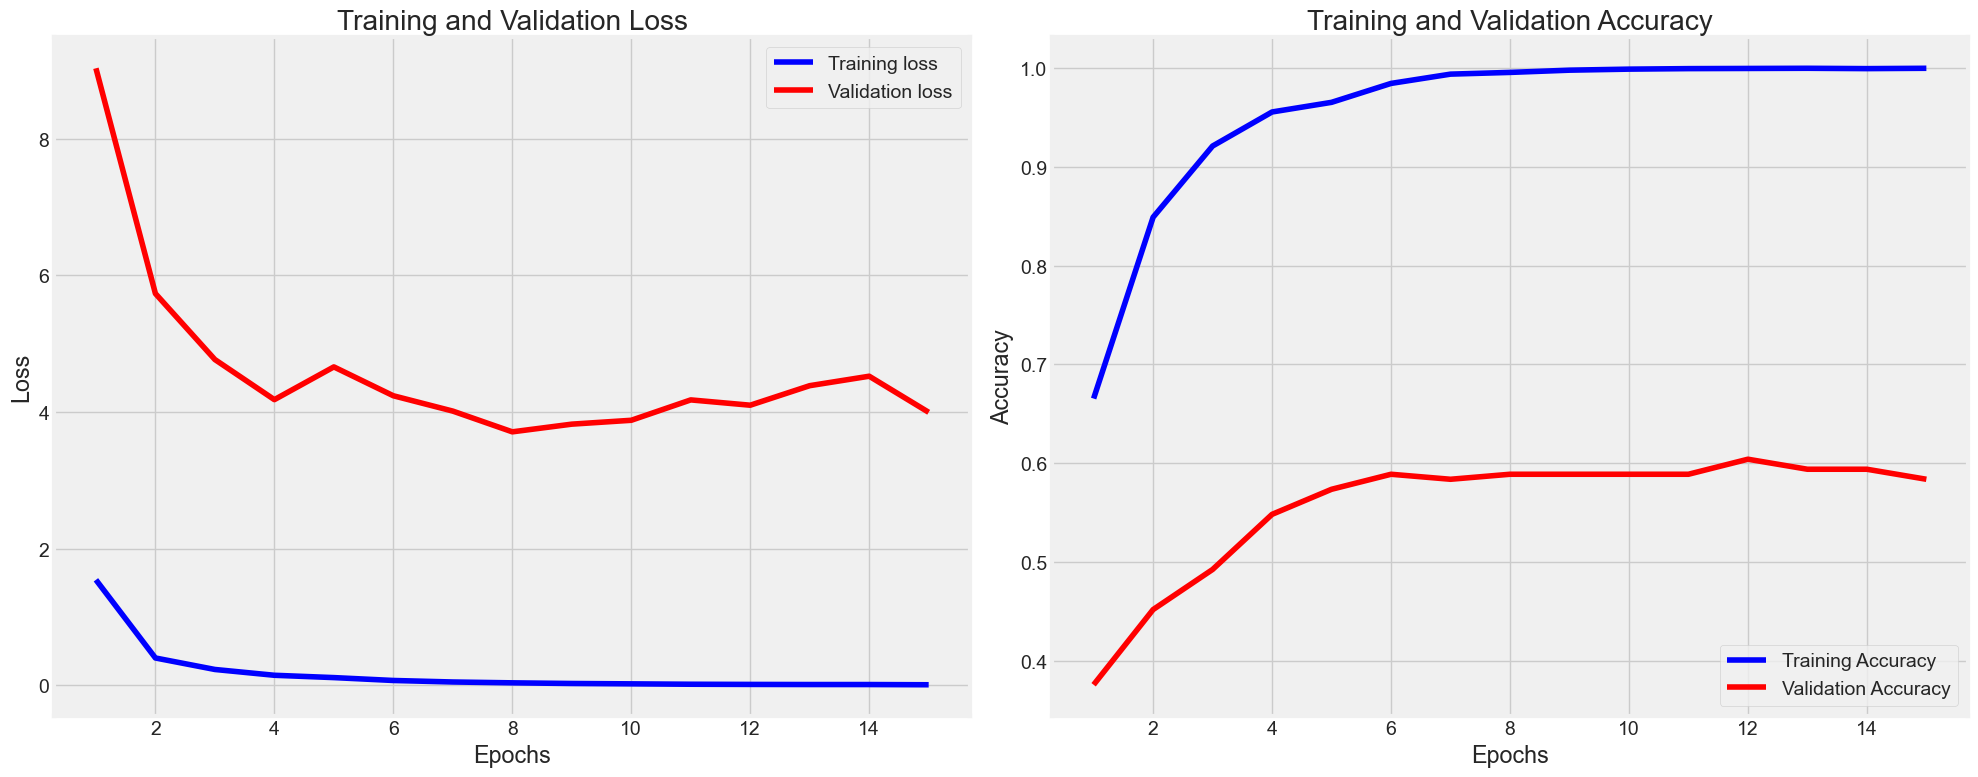

In [44]:
# Plots of training and validation accuracy

import matplotlib.pyplot as plt
import numpy as np


tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'b', label='Training loss')
plt.plot(Epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'b', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig('training_history_plots_augmentation.png')
plt.show()


In [20]:
tr_acc_finalXavier = history.history['accuracy']
val_acc_finalXavier = history.history['val_accuracy']


In [45]:
tr_acc_finalhe = history.history['accuracy']
val_acc_finalhe = history.history['val_accuracy']


In [38]:
tr_acc_finallec = history.history['accuracy']
val_acc_finallec = history.history['val_accuracy']


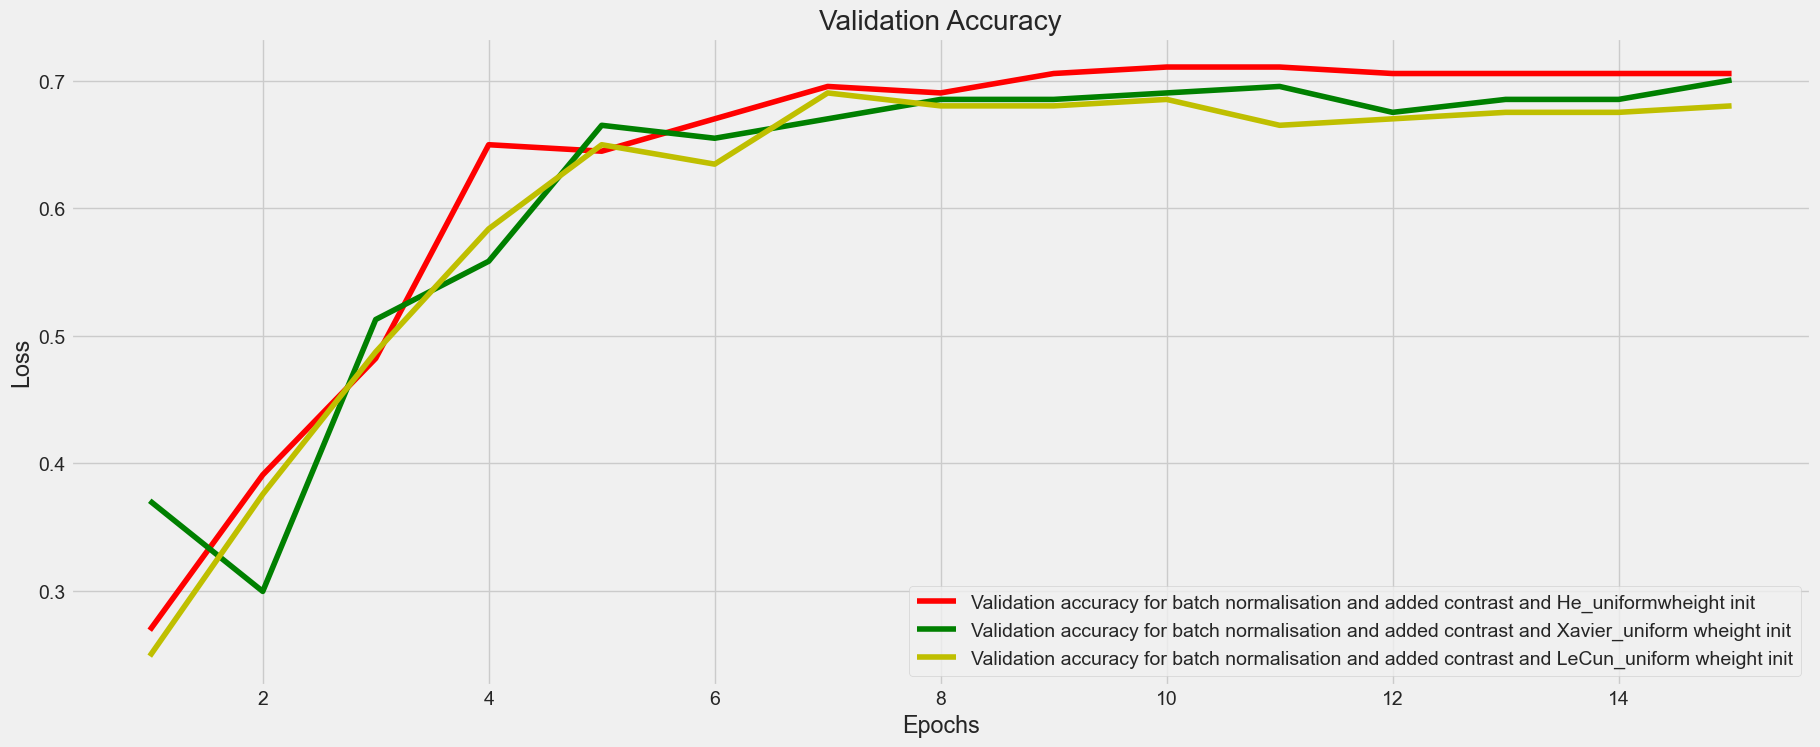

In [46]:
# Plots for normalisation and weight initialisation techniques 

import matplotlib.pyplot as plt
Epochs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.plot(Epochs, val_acc_finalhe, 'r', label='Validation accuracy for batch normalisation and added contrast and He_uniformwheight init')
plt.plot(Epochs, val_acc_finalXavier, 'g', label='Validation accuracy for batch normalisation and added contrast and Xavier_uniform wheight init')
plt.plot(Epochs, val_acc_finallec, 'y', label='Validation accuracy for batch normalisation and added contrast and LeCun_uniform wheight init')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_weight.png')

4/4 [==============================] - 1s 186ms/step


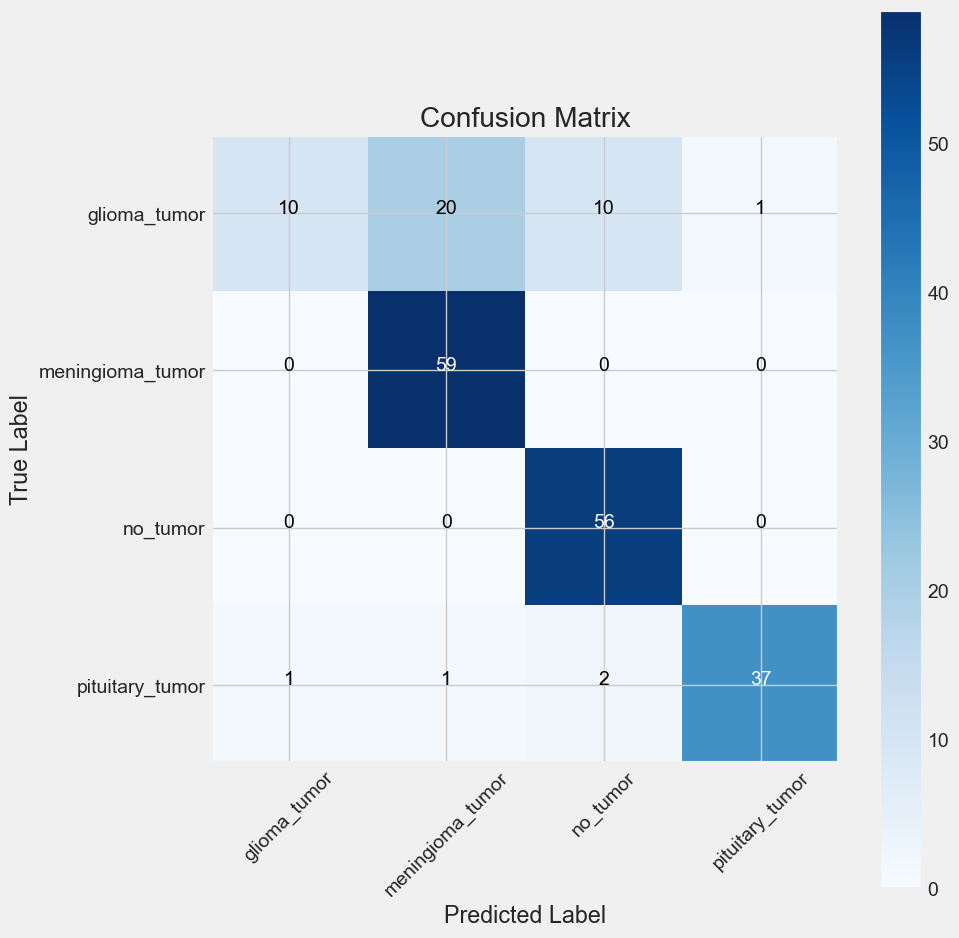

In [49]:
# Confusion matrix to see mis classified cases

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the plot
plt.savefig('confusion_matrix_dataset1_batchNorm_CLAHE_heinit.png')
plt.show()
